# load libraries

In [3]:
# %load test_fdbkpatt_similarity.py
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches
from matplotlib import ticker
from scipy.stats import ttest_rel

import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15

workdir = '/home/qin4/From_Compy/home_dir/'
datadir0 = '/p/user_pub/climate_work/qin4/From_Compy/compyfs_dir/'
figdir = workdir+'/scripts/published/figure/'

# workdir = '/qfs/people/qiny108/'
# datadir0 = '/compyfs/qiny108/'
# figdir = workdir+'/scripts/figure_v1v2/' 

import sys
sys.path.append(workdir+'diag_feedback_E3SM/')
import PlotDefinedFunction as PDF

from datetime import date
today = date.today()
dd = today.strftime("%Y-%m-%d")
print(dd)

2023-10-02


# read data

In [4]:
datadir = workdir+"diag_feedback_E3SM/data/"
figdir = workdir+"scripts/figure_v1v2/"

cases = ["v1","v2","v1.pert1e-14",'v1.All']
cases_out = ['v1','v2','v1.pert1e-14','v1.All']

var = 'netCRE_ano_grd_adj'
var_out = 'NET cloud feedback'

dics = {}
for case,case_out in zip(cases,cases_out):
    f1 = cdms.open(datadir+'lat-lon-gfdbk-CMIP6-'+case+'.nc')
    data = f1(var)
    dics[case_out] = data
    f1.close() 

d1 = dics['v2']-dics['v1']
d2 = dics['v2']-dics['v1.All']
d3 = dics['v1.All']-dics['v1']
d4 = dics['v1.pert1e-14']-dics['v1']
d5 = dics['v2']-dics['v1.pert1e-14']

## calculate spatial correlation between two cases
wts = np.cos(np.deg2rad(data.getAxis(0))) 
cor,NRMSE, RMSE = PDF.pattern_cor(dics['v2'],dics['v1'],wts,1) 
print('v2 vs v1     :', 'cor=',cor.round(2),'NRMSE=',NRMSE.round(2),'RMSE=',RMSE.round(2))

cor,NRMSE, RMSE = PDF.pattern_cor(dics['v2'],dics['v1.All'],wts,1) 
print('v2 vs v1.All :', 'cor=',cor.round(2),'NRMSE=',NRMSE.round(2),'RMSE=',RMSE.round(2))

cor,NRMSE, RMSE = PDF.pattern_cor(dics['v1'],dics['v1.All'],wts,1) 
print('v1 vs v1.All :', 'cor=',cor.round(2),'NRMSE=',NRMSE.round(2),'RMSE=',RMSE.round(2))


cor,NRMSE, RMSE = PDF.pattern_cor(d2,d1,wts,1) 
print('v2-v1 vs v2-v1.All :', 'cor=',cor.round(2),'NRMSE=',NRMSE.round(2),'RMSE=',RMSE.round(2))

std = np.std(d4)
print(std)

AXL = dics['v1'].getAxisList()

# =====================================
# Read anomaly for significance test
# =====================================
dics_st = {} 
for case,case_out in zip(['v1','v2','v1.All'],['v1','v2','v1.All']):
    f1 = cdms.open(datadir+'lat-lon-gfdbk-anom-CMIP6-'+case+'.nc')
    data = f1(var)
    dics_st[case_out] = data 
    f1.close() 
print('dics_st.keys()=',dics_st.keys())


v2 vs v1     : cor= 0.62 NRMSE= 0.87 RMSE= 70.21
v2 vs v1.All : cor= 0.66 NRMSE= 0.81 RMSE= 65.73
v1 vs v1.All : cor= 0.86 NRMSE= 0.53 RMSE= 42.76
v2-v1 vs v2-v1.All : cor= 0.8 NRMSE= 0.65 RMSE= 42.76
0.41645851497687225
dics_st.keys()= dict_keys(['v1', 'v2', 'v1.All'])


# Figure S3 - similarity

0.6482902540694406
0.6114527837419288
0.4614596379597185
-0.18683061610972215
-0.1499931457822103
-0.036837470327511904


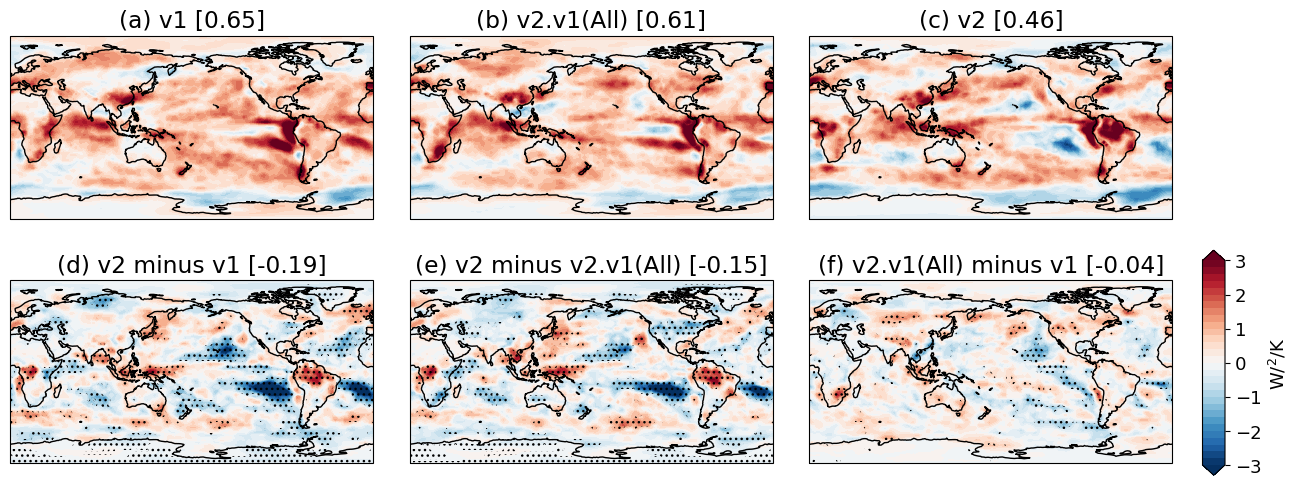

In [5]:
### plotting ####
fig = plt.figure(figsize=(15,9))
nrow = 3
ncol = 3

cmap = 'RdBu_r'

levels = np.arange(-3,3.2,0.2)
#levels1 = np.arange(-1,1.1,0.1)
levels1 = np.arange(-0.5,1.1,0.1)

datadA = [\
          dics['v1'],dics['v1.All'],dics['v2'],\
          d1, d2, d3, \
          ]
levelsA = [\
            levels, levels, levels,\
            levels, levels, levels,\
            ]
titlesA = [\
            'v1','v2.v1(All)', 'v2',\
            'v2 minus v1', 'v2 minus v2.v1(All)', 'v2.v1(All) minus v1',\
          ]
datatA = [
    None, None, None,
    [dics_st['v2'],dics_st['v1']], [dics_st['v2'],dics_st['v1.All']], [dics_st['v1.All'],dics_st['v1']],
]

for ii,datad in enumerate(datadA):

    datad.setAxisList(AXL)
    lons = datad.getLongitude()[:]
    lats = datad.getLatitude()[:]

    ax = fig.add_subplot(nrow,ncol,ii+1,projection=ccrs.PlateCarree(180))
    im = ax.contourf(lons,lats,datad,transform=ccrs.PlateCarree(),levels=levelsA[ii],cmap=cmap,extend='both')
    ax.coastlines()
    
    avgdatad = cdutil.averager(datad,axis='xy',weights='weighted')
    print(avgdatad)
    plt.title('('+chr(ord('`')+(ii+1))+') '+titlesA[ii]+' ['+str(np.round(avgdatad,2))+']')

    # =============================================================
    # add significance in the difference map
    # =============================================================
    if datatA[ii] != None:
        [x1,x2] = datatA[ii] 
        statres, pval = ttest_rel(x1,x2)  
        spy1 = np.where(pval < 0.05, 1, 0)
        ax.contourf(lons,lats,spy1, transform=ccrs.PlateCarree(),levels=[0.5,1.5],colors='none',hatches=['...','//'])  


# ------------- add common colorbar ----------------------
pos2 = [0.92, 0.38, 0.015, 0.25] # [x0,y0,width,height]
  
fh = 13

cbar_ax = fig.add_axes(pos2)
cb = fig.colorbar(im,ax=ax, orientation='vertical', cax=cbar_ax)
cb.set_label('W/$^2$/K',fontsize=fh)
cb.ax.tick_params(labelsize=fh)
tick_locator = ticker.MaxNLocator(nbins=7)
cb.locator = tick_locator
cb.update_ticks()

fig.subplots_adjust(wspace=0.1)

# fig.savefig(figdir+'LatLon_fdbkpatt_similarity_'+var+'_'+dd+'.pdf',bbox_inches='tight')
fig.savefig(figdir+'LatLon_fdbkpatt_similarity_'+var+'_'+dd+'.png', dpi=300, bbox_inches='tight')
fig.savefig(figdir+'LatLon_fdbkpatt_similarity_'+var+'_'+dd+'.pdf', bbox_inches='tight')
